# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Homework 3: CNN 

**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors:** Pavlos Protopapas and Mark Glickman<br/>

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">
### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import backend as K 
K.set_image_dim_ordering('tf')

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold 
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from astropy.table import Table

import glob
import h5py    

from PIL import Image
from scipy.misc import toimage
import skimage
from skimage import data, io
from skimage.transform import rescale, resize, downscale_local_mean

from matplotlib import pyplot
import matplotlib.pylab as plt 
from IPython.display import Image
%matplotlib inline

from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# if you do not have skimage then you may install is by running $ conda install -c anaconda scikit-image

Using TensorFlow backend.


In [3]:
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


<div class="theme"> Overview </div> 


In this homework, we will explore Convolutional Neural Networks (CNNs).  We'll explore the mechanics of convolutional operations, will build a CNN to classify CIFAR-10 images, and will build a CNN for detecting gravitational waves from the LIGO observatory. Specifically, we will use images generated from the raw time series data to train a model that can distinguish between real gravitational events and noise. 

<div class='exercise'><b> Question 1: Convolutional Neural Network Basics [33.333333pts] </b></div>


As you know from lecture, in convolutional neural networks, a convolution is a multiplicative operation on a local region of values. Convolutional layers have shown themselves to have been very useful in image classification, as they allows the network to retain local spatial information for feature extraction.

<span class='sub-q'>**1.1 Calculate Convolutions.**</span>

For the following 2D matrix:

$$
\left( \begin{array}{cccc}
2 & 3 & 2 & 4 \\
3 & 1 & 2 & 2 \\
4 & 1 & 0 & 1 \\
7 & 2 & 1 & 3
\end{array} \right)
$$

you will use the following 2x2 kernel to perform a 2D convolution operation.

$$
\left( \begin{array}{cc}
2 & 1 \\
1 & 3 
\end{array} \right)
$$
Compute this operation by hand assuming a vertical and horizontal stride of 1 as well as a) valid, b) same, and c) full border modes.  For each mode, indicate the shape of the the resulting (post-convolution) matrix and compare it to the shape of the original matrix.

<div class="alert alert-block alert-info">
<b> Vaild mode i.e. no padding </b> 
</div>

In [284]:
# pretty print arrays
# taken from user "braingineer" on github
# https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [285]:
# convolution function
def my_conv(M, conv, d=2):
    # d is the square dimension of the convolution
    out = np.zeros((M.shape[0]-1, M.shape[1]-1))
    for i in range(M.shape[0]-d+1):
        for j in range(0, M.shape[1]-d+1):
            temp = np.sum(np.multiply(M[i:i+d,j:j+d], conv))
            out[i,j] = temp
    return(out)

In [265]:
# define matrix 
M = np.array([2,3,2,4,3,1,2,2,4,1,0,1,7,2,1,3]).reshape(4,4)
# define convolution
conv = np.array([2,1,1,3]).reshape(2,2)

print('Matrix')
matprint(M)
print("\nConvolution operation")
matprint(conv)

Matrix
2  3  2  4  
3  1  2  2  
4  1  0  1  
7  2  1  3  

Convolution operation
2  1  
1  3  


In [89]:
# valid conv
valid_conv = my_conv(M, conv)
print("Convolution Result with No Padding")
matprint(valid_conv)

Convolution Result with No Padding
13  15  16  
14   5   9  
22   7  11  


<div class="alert alert-block alert-info">

We see from the above the result of the convolution with no padding (valid borders). As expected, we see that a kernel of size (2,2) with horizontal and vertical strides reduces the length of each dimension of the matrix by 1. 

</div>

<div class="alert alert-block alert-info">
<b> Same padding </b> 
</div>

In [80]:
# produce new matrix with same padding
M_same = np.zeros((M.shape[0]+1, M.shape[1]+1))
M_same[:M.shape[0],:M.shape[1]] = M
print('Same Padded Matrix')
matprint(M_same)

Same Padded Matrix
2  3  2  4  0  
3  1  2  2  0  
4  1  0  1  0  
7  2  1  3  0  
0  0  0  0  0  


In [81]:
# same padding
same_conv = my_conv(M_same, conv)
print("Convolution Result with Same Padding")
matprint(same_conv)

Convolution Result with Same Padding
13  15  16  10  
14   5   9   5  
22   7  11   5  
16   5   5   6  


<div class="alert alert-block alert-info">

We see from the above the result of the convolution with same padding. As expected, we see that the dimensions of the orginal matrix - (4,4) - are kept intact. 

</div>

<div class="alert alert-block alert-info">
<b> Full border padding </b> 
</div>

In [82]:
# produce new matrix with full border padding
M_full = np.zeros((M.shape[0]+2, M.shape[1]+2))
M_full[1:M.shape[0]+1,1:M.shape[1]+1] = M
print('Full Padded Matrix')
matprint(M_full)

Full Padded Matrix
0  0  0  0  0  0  
0  2  3  2  4  0  
0  3  1  2  2  0  
0  4  1  0  1  0  
0  7  2  1  3  0  
0  0  0  0  0  0  


In [83]:
# full padding
full_conv = my_conv(M_full, conv)
print("Convolution Result with Full border Padding")
matprint(full_conv)

Convolution Result with Full border Padding
 6  11   9  14   4  
11  13  15  16  10  
15  14   5   9   5  
25  22   7  11   5  
 7  16   5   5   6  


<div class="alert alert-block alert-info">

We see from above the result of the convolution with full border padding. As expected, we that the output result of convolution has larger dimensions that the original matrix; the ouput is now of size (5,5).

<br>
<br>

Importantly, we see that each ellement of the original array is visited the same number of times - 4 in this case. 

</div>

<span class='sub-q'>**1.2 Understanding Pooling Operations.**</span>

Pooling operations are often used in convolutional neural networks to reduce the dimensionality of the feature maps as well as overall network complexity. Two main types of pooling are used: AveragePooling and MaxPooling.

**1.2.1.** Using the matrix below, write the output of the AveragePooling and MaxPooling operations with pool size 2x2 and stride  2x2.

$$
\left( \begin{array}{cccc}
1 & 2 & 2 & 4 \\
3 & 1 & 2 & 1 \\
4 & 1 & 0 & 2 \\
5 & 2 & 2 & 1
\end{array} \right)
$$

In [196]:
# average ppoling function
def my_pool(M, s, avg=True):
    # default average pooling 
    # otherwise max pooling
    # s = stide
    
    # shape
    m,n = M.shape

    # loop through
    out = np.zeros((m-s,n-s))
    indsI = np.array(range(0,m-(s%2),s))
    indsJ = np.array(range(0,n-(s%2),s))
    for I,i in enumerate(indsI):
        for J,j in enumerate(indsJ): 
            if avg:
                temp = np.sum(M[i:i+2,j:j+2])/4
            else:
                temp = np.max(M[i:i+2,j:j+2])
            out[I,J] = temp
    return(out)

In [202]:
# define matrix
M2 = np.array([1,2,2,4,3,1,2,1,4,1,0,2,5,2,2,1]).reshape(4,4)
print('Matrix')
matprint(M)

Matrix
2  3  2  4  
3  1  2  2  
4  1  0  1  
7  2  1  3  


<div class="alert alert-block alert-info">
<b> AveragePooling, Stride of (2,2), PoolSize of (2,2) </b> 
</div>

In [203]:
print("AveragePooling, Stride of (2,2), PoolSize of (2,2) ")
matprint(my_pool(M2,2))

AveragePooling, Stride of (2,2), PoolSize of (2,2) 
1.75  2.25  
   3  1.25  


<div class="alert alert-block alert-info">
<b> MaxPooling, Stride of (2,2), PoolSize of (2,2) </b> 
</div>

In [211]:
print("MaxPooling, Stride of (2,2), PoolSize of (2,2) ")
matprint(my_pool(M2,2, avg=False))

MaxPooling, Stride of (2,2), PoolSize of (2,2) 
3  4  
5  2  


**1.2.2.** Repeat 1.2.1 with a stride of size 1.

<div class="alert alert-block alert-info">
<b> AvgPooling, Stride of (1,1), PoolSize of (2,2) </b> 
</div>

In [207]:
print("AvgPooling, Stride of (1,1), PoolSize of (2,2) ")
matprint(my_pool(M2,1))

AvgPooling, Stride of (1,1), PoolSize of (2,2) 
1.75  1.75  2.25  
2.25     1  1.25  
   3  1.25  1.25  


<div class="alert alert-block alert-info">
<b> MaxPooling, Stride of (1,1), PoolSize of (2,2) </b> 
</div>

In [210]:
print("MaxPooling, Stride of (1,1), PoolSize of (2,2) ")
matprint(my_pool(M2,1, avg=False))

MaxPooling, Stride of (1,1), PoolSize of (2,2) 
3  2  4  
4  2  2  
5  2  2  


Consider the following image of a dog:

![dog](data/Kintamani_dog_white_gs.jpeg)

**1.3.1.** Load the image as a 2D Numpy array into the variable `dog_image_data`. Appropriately normalize the image data so that values within `dog_image_data` fall within [-0.5, 0.5].  .



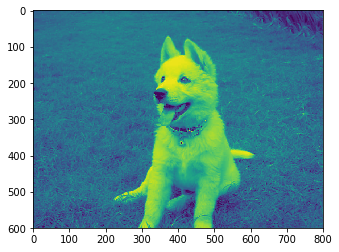

In [286]:
# load image
dog_image_data = plt.imread('data/Kintamani_dog_white_gs.jpeg')
# choose first channel
dog_data = dog_image_data[...,0].astype(float)
# dislay
plt.imshow(dog_data);

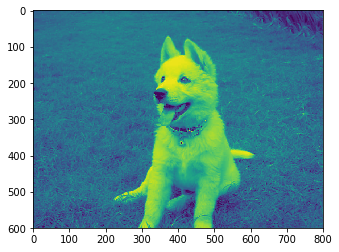

In [287]:
# noramlize 
# [a,b]
# x = [(b-a) * (x-min)/(max-min)] + a
a = -0.5
b = 0.5
d_min = dog_data.min()
d_max = dog_data.max()
dog_data = ((b-a)*((dog_data - d_min)/(d_max-d_min))) + a
plt.imshow(dog_data);

**1.3.2.** Choose three 3x3 convolution kernels (you can look up kernels for edge detection, normalized box blurring, and sharpening, see https://en.wikipedia.org/wiki/Kernel_(image_processing) for example), and apply each of these kernels to the image with same border mode (you may want to implement your own convolution function or try using  [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)).





In [288]:
# edge detections
# first kernel: edge
conv1 = np.array([-1,-1,-1,-1,8,-1,-1,-1,-1]).reshape(3,3)
print("Edge Convolution Kernel 1")
matprint(conv1)

# second kernel: sharpen
print("\nSharpen Convolution Kernel 2")
conv2 = np.array([0,-1,0,-1,5,-1,0,-1,0]).reshape(3,3)
matprint(conv2)

# third kernel: blur
print("\nBox Blur Convolution Kernel 3")
conv3 = (1/9)*np.array([1,1,1,1,1,1,1,1,1]).reshape(3,3)
matprint(conv3)

Edge Convolution Kernel 1
-1  -1  -1  
-1   8  -1  
-1  -1  -1  

Sharpen Convolution Kernel 2
 0  -1   0  
-1   5  -1  
 0  -1   0  

Box Blur Convolution Kernel 3
0.111111  0.111111  0.111111  
0.111111  0.111111  0.111111  
0.111111  0.111111  0.111111  


In [289]:
# perform convolutions 
dog_conv1 = my_conv(dog_data, conv1, 3)
dog_conv2 = my_conv(dog_data, conv2, 3)
dog_conv3 = my_conv(dog_data, conv3, 3)

**1.3.3.** In the resulting convolved image data matrices, set all pixel values less than zero to zero (using np.clip()). In other words:


`
if x < 0:
    x = 0
else:
    x = x
`

(This is the `ReLU` activation function.)




In [290]:
# activate with relu
dog_conv1_relu = dog_conv1.clip(min=0)
dog_conv2_relu = dog_conv2.clip(min=0)
dog_conv3_relu = dog_conv3.clip(min=0)

**1.3.4.** Show plots of the resulting images. 




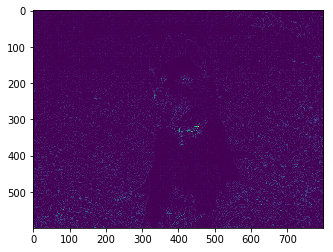

In [312]:
# plots conv1: edge 
plt.imshow(dog_conv1_relu);

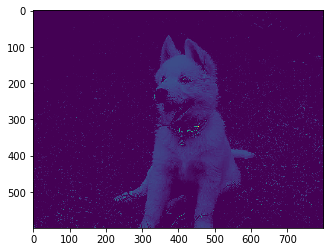

In [313]:
# plot conv2: sharpen
plt.imshow(dog_conv2_relu);

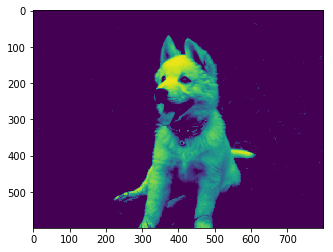

In [314]:
# plot conv3: box blur
plt.imshow(dog_conv3_relu);

**1.3.5.** Take a moment to examine the convolved images. You should see that certain features in the puppy are accentuated, while others are de-emphasized. What might be the effect of performing additional convolution operations on these filtered images and how might they relate to additional layers in a neural network?


<div class="alert alert-block alert-info">

From the edge convolution matrix, we see that the convolved matrix has its edges and outlines enhanced. From the sharpen convolution matrix, we see that the convolved matrix has the dog sharpened in the image and not the surrouding areas. From the box blur convolution matrix, we see that the convolved matrix has the dog image blurred without affecting the surrounding features. Adding further convolutional layers has the affect of emphasizing more and more specific features in the data i.e. edges to circles to circles on top of circles. This is exactly how the neural network with convolutional layers works i.e. by building ever increaseingly complex features one on top of another through the layers in the network. 

</div>

<div class='exercise'><b> Question 2: Building a Basic CNN Model [33.33333pts] </b></div>

In this question, you will use Keras to create a convolutional neural network for predicting the type of object shown in images from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset, which contains 50,000 32x32 training images and 10,000 test images of the same size, with a total of 10 classes.


<span class='sub-q'> **2.1 Loading CIFAR-1O and Constructing the Model. **</span>

Load CIFAR-10 and use a combination of the [following layers](https://keras.io/layers/convolutional/): Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order) to build your model.
You may use an existing architecture like AlexNet or VGG16, or create one of your own design. However, you should write your own layers and not use a pre-written implementation.

Convolutional neural networks are very computationally intensive. We highly recommend that you train your model on a system using GPUs. On CPUs, this training can take up to several hours. On GPUs, it can be done within minutes.

You can approach the problems in this question by first creating a model assigning 32 filters to each Conv2D layer recreate the model with 64 filters/layer, 128, etc.  For each generated model, keep track of the total number of parameters.

**2.1.1.** Report the total number of parameters in your model.

**2.1.2.** How does the number of total parameters change (linearly, exponentially) as the number of filters per layer increases?

**2.1.3.** Generate a plot showing the relationship in 2.1.2 and explain what you see.



In [4]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train.shape

(50000, 32, 32, 3)

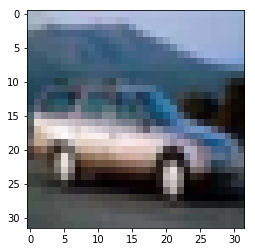

In [263]:
# plot an image 
image = x_train[4,...]
image_class = y_train[4]
plt.imshow(image);

In [264]:
print('Train')
print(x_train.shape)
print()
print('Test')
print(x_test.shape)

Train
(50000, 32, 32, 3)

Test
(10000, 32, 32, 3)


In [265]:
# normalize
x_train = x_train/255
x_test = x_test/255

In [266]:
# create output vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

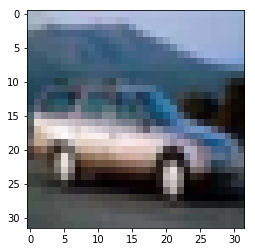

In [267]:
# plot a figure
image = x_train[4,...]
plt.imshow(image);

<div class="alert alert-block alert-info">

Build and look at a few models.  

</div>

In [7]:
def build_cnn(filter_size):
    # build model
    cnn = Sequential()
    cnn.add(Conv2D(filters= filter_size, kernel_size= (3,3), 
                   strides= (1,1), padding= 'valid', input_shape= x_train.shape[1:],
                   activation= 'relu'))
    cnn.add(Conv2D(filters= filter_size, kernel_size= (3,3), 
                   strides= (1,1), padding= 'valid', input_shape= x_train.shape[1:], 
                   activation= 'relu'))
    cnn.add(MaxPooling2D(pool_size= (2, 2)))
    cnn.add(Conv2D(filters= filter_size, kernel_size= (3,3), 
                   strides= (1,1), padding= 'valid', input_shape= x_train.shape[1:], 
                   activation= 'relu'))
    cnn.add(MaxPooling2D(pool_size= (2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(512, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(10, activation='softmax'))
    return(cnn)

In [8]:
def plot_nn(ann, title=''):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(ann.history.history['acc'], color='blue', label='Accuracy')
    ax.plot(ann.history.history['loss'], color='orange', label='Loss')
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend();

<div class="alert alert-block alert-info">

<b> 32 filter layers $\rightarrow$ 743,626 total parameters bellow </b>

</div>

10000/10000 [==============================] - 1s 103us/step
[1.6088743253707887, 0.7105]


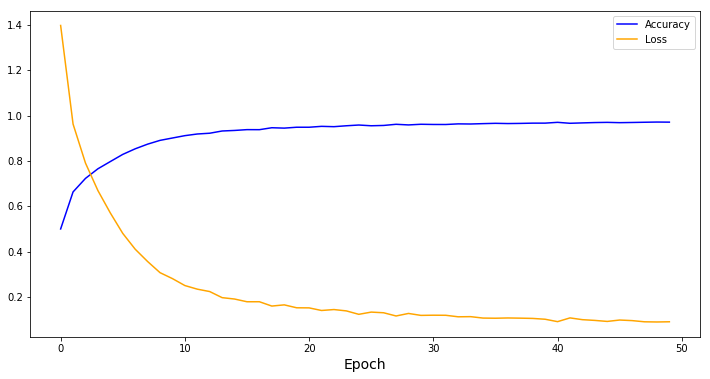

In [390]:
# build cnn 
cnn1 = build_cnn(filter_size=32)
# compile it
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# fit it 
cnn1.fit(x_train, y_train, batch_size = 64, epochs=50)
# plot cnn
plot_nn(cnn1)
# save model
cnn1.save("cnn1.h5")
# evaluate
print(cnn1.evaluate(x_test, y_test))

In [393]:
# summary
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               590336    
__________

In [29]:
# n parameters
n_32f = 743626

<div class="alert alert-block alert-info">

<b> 64 filter layers $\rightarrow$ 1,389,706 total parameters bellow </b>

</div>

10000/10000 [==============================] - 1s 149us/step
[1.7674060056209564, 0.7073]


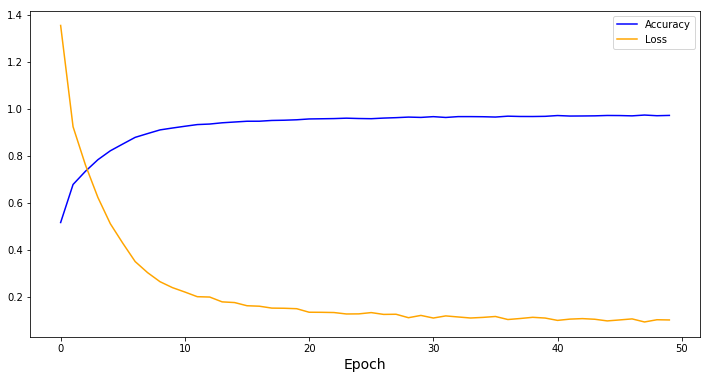

In [392]:
# build cnn 
cnn2 = build_cnn(filter_size=64)
# compile it
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# fit it 
cnn2.fit(x_train, y_train, batch_size = 64, epochs=50)
# plot cnn
plot_nn(cnn2)
# save model
cnn2.save("cnn2.h5")
# evaluate
print(cnn2.evaluate(x_test, y_test))

In [395]:
# summary
cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1180160   
__________

In [28]:
# n parameters
n_64f = 1389706

<div class="alert alert-block alert-info">

<b> 128 filter layers $\rightarrow$ 2,792,458 total parameters bellow </b>

</div>

10000/10000 [==============================] - 2s 210us/step
[1.9773164527893066, 0.6997]


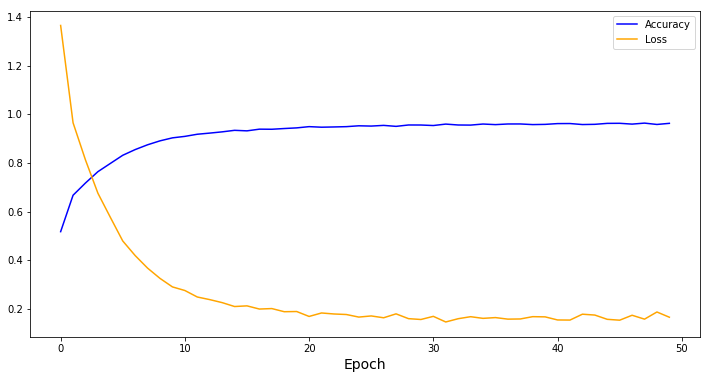

In [396]:
# build cnn 
cnn3 = build_cnn(filter_size=128)
# compile it
cnn3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# fit it 
cnn3.fit(x_train, y_train, batch_size = 64, epochs=50)
# plot cnn
plot_nn(cnn3)
# save model
cnn3.save("cnn3.h5")
# evaluate
print(cnn3.evaluate(x_test, y_test))

In [397]:
# summary
cnn3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               2359808   
__________

In [27]:
# n parameters
n_128f = 2792458

<div class="alert alert-block alert-info">

<b> 256 filter layers $\rightarrow$ 6,040,330 total parameters bellow </b>

</div>

In [24]:
cnn=build_cnn(256)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 256)       590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4719104   
__________

In [26]:
# n parameters
n_256f = 6040330

<div class="alert alert-block alert-info">

<b> 256 filter layers $\rightarrow$ 14,305,546 total parameters bellow </b>

</div>


In [33]:
cnn=build_cnn(512)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 512)       14336     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 512)       2359808   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 512)       2359808   
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               9437696   
__________

In [35]:
n_512f = 14305546

<div class="alert alert-block alert-info">

In each of the above models, the architecture stays the same for the most part. What changes throughout the models is the number of filter $n_f$ which is used to build each convolutional layer in the model i.e. we go from having $k$ convolutional layers of 32 filters per layer to 64, 128, 256, and 512 filters.

<br> <br>

From above, we see how the total number of paramters changes throughout the models. For 32, 64, and 128 filters, we go from 743626 to 1389706 to 2792458 total parameters. The ratio of the total number of parameters in 64 filter model over the 32 filter model is approximately 1.87. That same ratio for the 128 filter model to the 64 filter model is approximately 2. For the 256 to the 128 and the 512 to the 256 ratios, we get approximately 2.16 and 2.37.   

<br>
<br>

These latter ratios tell us how the total number of parameters change, but to get a sense for how the total number of parameters changes with the number of filters, consider the number of parameters in the first convolutional layer of each model.  For 32, 64, and 128 filters, the number of parameters increases from 896 to 1792 ($=896\cdot2$) to 3584 ($=1792\cdot2$). This tells us that a doubling in the filter size of the first convolutional layer causes a doubling in the number of parameters. This makes sense. The number of parameters in a convolutional layer is equal to $((k\cdot k \cdot n_c \cdot n_f) + n_f)$ where $k$ represents the dimensional length of the convolutional square, $n_c$ is the number of channels from the input, and $n_f$ is the number of filters. For the first layer, going form $n_{f,32}=32$ to $n_{f,64}=64 = 2 \cdot n_{f,32}$ describes a linear relationship. 

Let's, however, let's look at the second convolutional layer. In these subsequent layers, the number of channels becomes equal to the number of filters from the previous layer - i.e. the initial channel size of three from the data changes - and since we use the same number of filters for each convolution throughout a given model, the channel size for each convolution is equal to the number of filters for that convolution. Thus, when we change the number of filters per convolution from $n_f$ to $2n_f$ we change the number of parameters in that layer from $n_l = ((k\cdot k \cdot n_f \cdot n_f) + n_f)$ to $((k\cdot k \cdot 2n_f \cdot 2n_f) + 2n_f) = 2((k\cdot k \cdot n_f \cdot n_f) + n_f) \approx 4n_l$. We see this ratio in the second convolutional layer where the number of parameters in that layer for filter size of 32, 64, and 128 is 9248, 36928, and 147584, respectively. The ratio between the filter size of 128 to 64 and the ration of the 64 size to 32 are $\frac{36928}{9248} \approx \frac{147584}{36928} \approx 4$.

<br> <br>

Essentially, the number of parameters per convolutional layer increases by about a factor of 4 for a doubling in the filter size. The apparent discrepency we see in the total number of parameters in the first paragraph is a result of the massive number of dense parameters outweighing the convolutional parameters. As the number of parameters from the convolutional layer increases, we see the factor of 4 emerge. 

<br> <br>

We see this latter relationship in the below graphs. The total number of parameters steadily increases with the filter size. For the ratios between filter sizes, we see a sigmoidal curve which flattens out at the ratio of 4 as predicted. 

</div>

In [109]:
# total number of parameters 
# paramters obtained from building successive models with build function
filters = []
for i in range(13):
    filters.append(32*np.power(2,i))

nt_params = [n_32f, n_64f, n_128f, n_256f, 14305546, 37913866, 113442058, 
          377744650, 1359334666, 5134454026, 19932450058, 78519471370, 311657630986]
# there ratios
nt_ratios = []
for i in range(len(nt_params)-1):
    nt_ratios.append(nt_params[i+1]/nt_params[i])

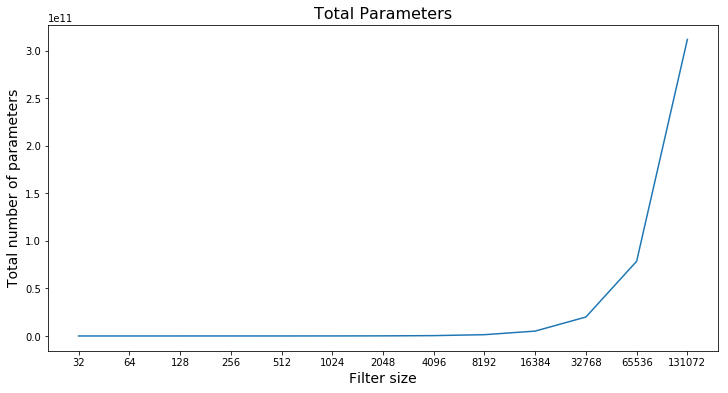

In [110]:
# plot total number of parameters
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(nt_params);
ax.set_xticks(list(range(len(nt_params))))
ax.set_xticklabels(filters)
ax.set_xlabel('Filter size', fontsize=14)
ax.set_ylabel('Total number of parameters', fontsize=14)
ax.set_title('Total Parameters', fontsize=16);

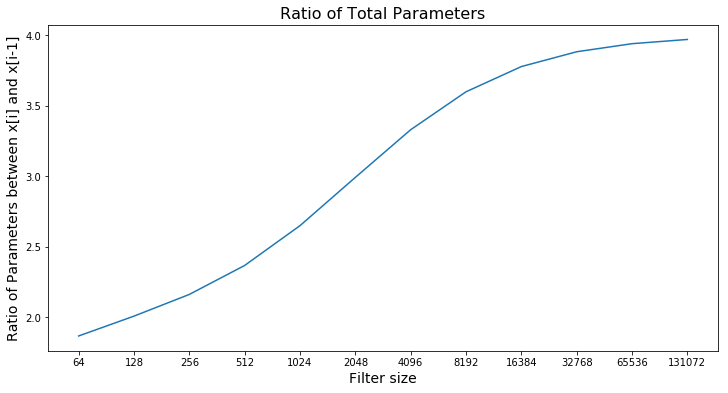

In [111]:
# plot ratios
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(nt_ratios);
ax.set_xticks(list(range(len(nt_ratios))))
ax.set_xticklabels(filters[1:])
ax.set_xlabel('Filter size', fontsize=14)
ax.set_ylabel('Ratio of Parameters between x[i] and x[i-1]', fontsize=14)
ax.set_title('Ratio of Total Parameters', fontsize=16);

<div class="alert alert-block alert-info">

<b> Validating for a model</b>

</div>

In [13]:
# create validation set
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1234)

In [14]:
def build_cnn_2(filter_size):
    # build model
    cnn = Sequential()
    cnn.add(Conv2D(filters= filter_size, kernel_size= (3,3), 
                   strides= (1,1), padding= 'valid', input_shape= x_train.shape[1:],
                   activation= 'relu', kernel_initializer = 'glorot_normal'))
    cnn.add(Conv2D(filters= filter_size, kernel_size= (3,3), 
                   strides= (1,1), padding= 'valid', input_shape= x_train.shape[1:],
                   activation= 'relu', kernel_initializer = 'glorot_normal'))
    cnn.add(MaxPooling2D(pool_size= (2, 2)))
    cnn.add(Conv2D(filters= filter_size, kernel_size= (3,3), 
                   strides= (1,1), padding= 'valid', input_shape= x_train.shape[1:], 
                   activation= 'relu',  kernel_initializer = 'glorot_normal'))
    cnn.add(MaxPooling2D(pool_size= (2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(512, activation='relu', kernel_initializer = 'glorot_normal'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(512, activation='relu', kernel_initializer = 'glorot_normal'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(10, activation='softmax',  kernel_initializer = 'glorot_normal'))
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
    cnn.summary()
    return(cnn)

In [15]:
# neural net plot
def plot_nn_2(nn, title=''):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(nn.history.history['acc'], color='blue', label='Train Accuracy')
    ax.plot(nn.history.history['val_acc'], color = 'blue', linestyle='-.', label= "Validation Accuracy")
    ax.plot(nn.history.history['loss'], color='orange', label='Train Loss')
    ax.plot(nn.history.history['val_loss'], color='orange', linestyle='-.', label='Val Loss')
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend();

<div class="alert alert-block alert-info">

<b> 32 Filters </b>

</div>

In [16]:
# build it 
cnn4 = build_cnn_2(32)
# callbacks 
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='cnn4.h5', monitor='val_loss', save_best_only=True)]
# compile it
cnn4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# fit it
cnn4.fit(X_train, Y_train, 
         batch_size = 64,
         epochs= 30,
         callbacks= callbacks,
         validation_data = (X_val, Y_val))
# plot cnn
plot_nn_2(cnn4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               590336    
__________

ValueError: Error when checking target: expected dense_6 to have shape (10,) but got array with shape (1,)

<div class="alert alert-block alert-info">

<b> 64 Filters </b>

</div>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               1180160   
__________

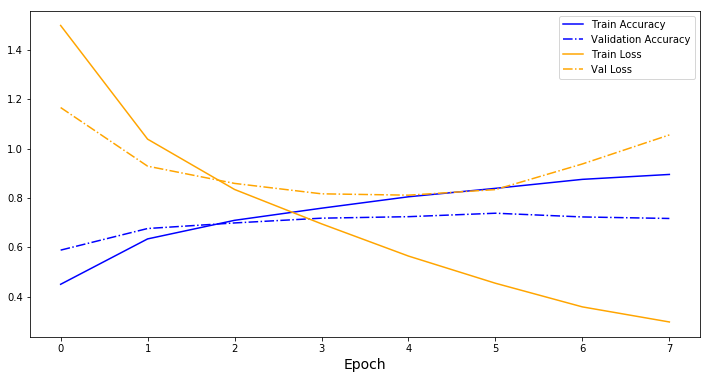

In [39]:
# build it 
cnn5 = build_cnn_2(64)
# callbacks 
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='cnn5.h5', monitor='val_loss', save_best_only=True)]
# compile it
cnn5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# fit it
cnn5.fit(X_train, Y_train, 
         batch_size = 64,
         epochs= 30,
         callbacks= callbacks,
         validation_data = (X_val, Y_val))
# plot cnn
plot_nn_2(cnn5)

<div class="alert alert-block alert-info">

<b> 128 Filters </b>

</div>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               2359808   
__________

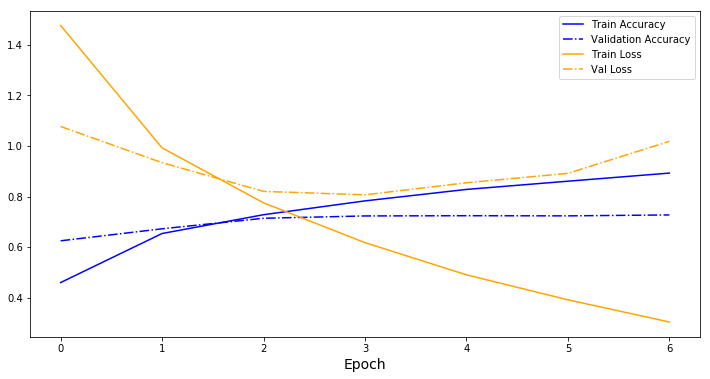

In [40]:
# build it 
cnn6 = build_cnn_2(128)
# callbacks 
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='cnn5.h5', monitor='val_loss', save_best_only=True)]
# compile it
cnn6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# fit it
cnn6.fit(X_train, Y_train, 
         batch_size = 64,
         epochs= 30,
         callbacks= callbacks,
         validation_data = (X_val, Y_val))
# plot cnn
plot_nn_2(cnn6)

In [41]:
# save models
cnn4.save('cnn4.h5')
cnn5.save('cnn5.h5')
cnn6.save('cnn6.h5')

<span class='sub-q'> **2.2 Choosing a Model, Training and Evaluating It. **</span>

**2.2.1.** Choose a model from 2.1 and train it. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs.  Your validation accuracy should exceed 70%. Training for 10 epochs on a CPU should take about 30-60 minutes.

**2.2.2.** Plot the loss and validation accuracy for your chosen architecture.

In [62]:
# cnn4 = load_model('cnn4.h5')
# cnn5 = load_model('cnn5.h5')
# cnn6 = load_model('cnn6.h5')

In [42]:
# evaluate models on validation
print(cnn4.evaluate(X_val, Y_val))
print(cnn5.evaluate(X_val, Y_val))
print(cnn6.evaluate(X_val, Y_val))

10000/10000 [==============================] - 1s 105us/step
[1.0364972272872925, 0.7215]
10000/10000 [==============================] - 1s 138us/step
[1.0552681411743163, 0.7166]
10000/10000 [==============================] - 2s 200us/step
[1.0183101798057557, 0.7271]


<div class="alert alert-block alert-info">

With our validation, we see validation accuracy exceed 70% across the board. Since the 32 filter layer is the least complicated, we will choose it to run for 30 epochs to see if perhaps it got stuck in a local minima. We will do the same for the 128 filter model.  

</div>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               590336    
__________

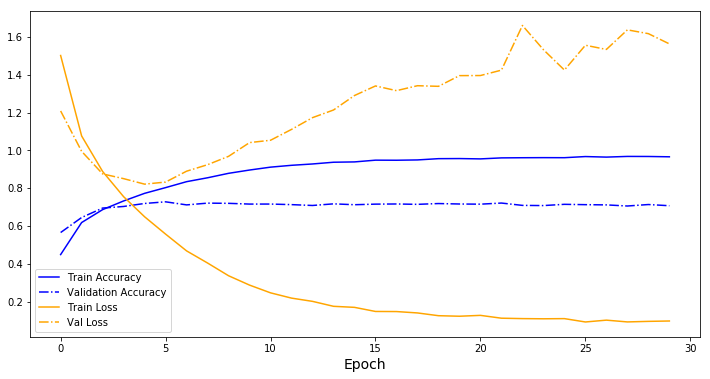

In [43]:
# build it 
cnn7 = build_cnn_2(32)
# compile it
cnn7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# fit it
cnn7.fit(X_train, Y_train, 
         batch_size = 64,
         epochs= 30,
         validation_data = (X_val, Y_val))
# plot cnn
plot_nn_2(cnn7)

In [44]:
# evaluate 
print(cnn7.evaluate(X_val, Y_val))

10000/10000 [==============================] - 1s 89us/step
[1.5623491720199585, 0.7086]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               2359808   
__________

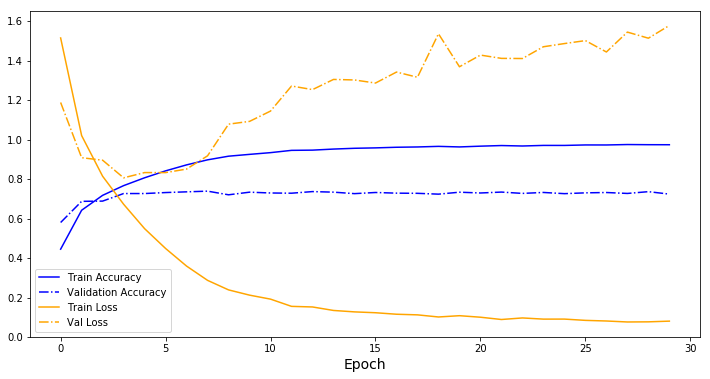

In [47]:
# build it 
cnn8 = build_cnn_2(128)
# compile it
cnn8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# fit it
cnn8.fit(X_train, Y_train, 
         batch_size = 64,
         epochs= 30,
         validation_data = (X_val, Y_val))
# plot cnn
plot_nn_2(cnn8)

In [48]:
# evaluate 
print(cnn8.evaluate(X_val, Y_val))

10000/10000 [==============================] - 2s 199us/step
[1.5780623582839965, 0.7242]


<div class="alert alert-block alert-info">

The above tells us that our validation with early stopping worked. We choose CNN model 'cnn6' - built with a 128 filter size and run with EarlyStopping to evaluate on the test. 

</div>

In [50]:
# evaluate cnn6 on test
print(cnn6.evaluate(x_test, y_test))

10000/10000 [==============================] - 2s 213us/step
[1.0295769912719726, 0.7288]


In [51]:
# save models
cnn7.save('cnn7.h5')
cnn8.save('cnn8.h5')

<span class='sub-q'>**2.3 Using Feature Maps to Visualize the Model.**</span>

We would gain an intution into how our model is processing the inputs in two ways.  First we'll ask you to use feature maps to visualize the activations in the intermediate layers of the network. We've provided a helper function `get_feature_maps` to aid in extracting weights from layers in your model network.  Feel free to take advantage of it if you'd like.  We'll also ask you to use [saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input (image in this case).

**2.3.1.** For a given input image, use your model and extract 9 feature maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid.  Make sure to plot (and clearly label) your original input image as well.

**2.3.2.** For the same input image generate and plot a saliency map to show the pixels in the image most pertinent to classification.  While you're welcome to generate the saliency map by hand, we highly recommend that you install and use [keras-vis](https://github.com/raghakot/keras-vis) and let it handle the generation.

**Hints:**

- If you assign a name to your last layer using the `name` parameter in the `Dense` layer, you'll be able to use the `find_layer_idx` function provided by keras-vis via `vis.utils.utils`
- As the keras-vis docs state: "To visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide utils.apply_modifications to modify network parameters and rebuild the graph."
- If your model is stored in a variable `model` then the following code will switch the softmax activation.

```
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)
```

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

<div class="alert alert-block alert-info">

<b> Feature Maps </b>

</div>

In [241]:
# define model
model = load_model('cnn6.h5')

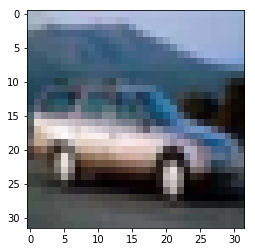

In [268]:
# image 
plt.imshow(image);

In [269]:
# second convolution
_feats = get_feature_maps(model, 1, image)

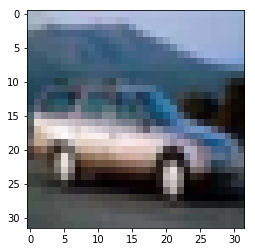

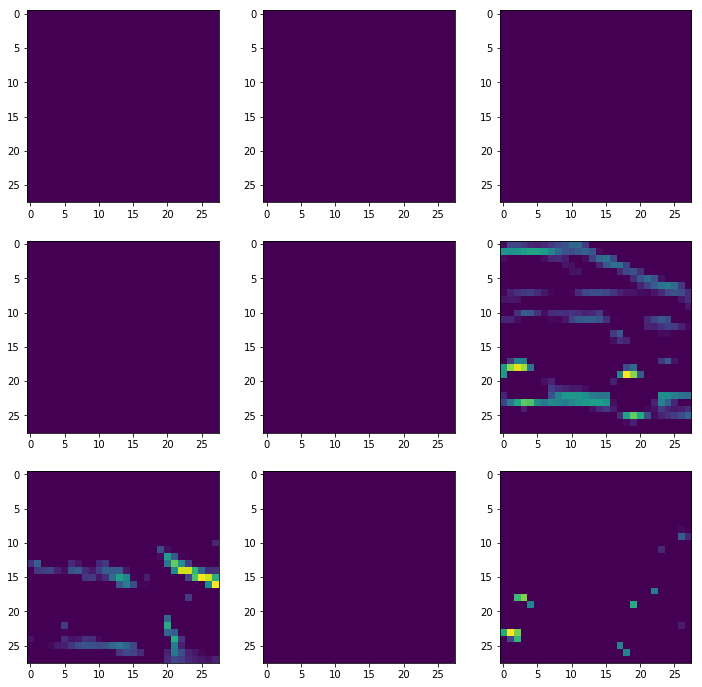

In [270]:
# plot 
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.imshow(image)
fig, ax = plt.subplots(3,3, figsize=(12,12))
count = 0
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(_feats[count,...])
        count+=1

<div class="alert alert-block alert-info">

We see from the above maps that the second convolutional layer seems to be picking up the curves of the car. In particular, the map on the second row, third column of the plot characterizes the outline of the car, its doors, and the wheels. The feature on the third row, first column charactersizes the hood of the car and the level fround on which the car rests. These more complex features are the results of the more fundamental features in the first convolutional layer that must have been built i.e. edges and straight lines to curves and circles. 

</div>

<div class="alert alert-block alert-info">

<b> Saliency Maps </b>

</div>

In [271]:
# Swap softmax with linear
model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

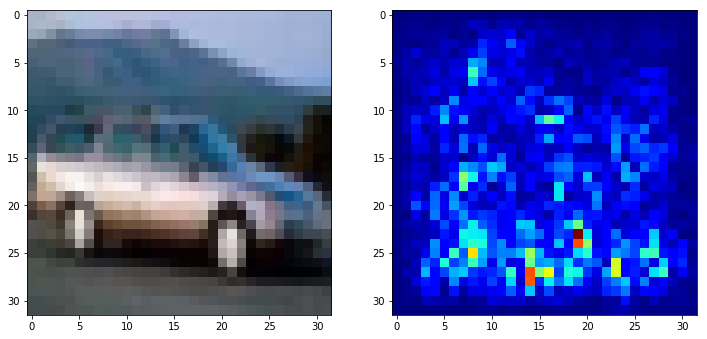

In [280]:
fig, ax = plt.subplots(1,2, figsize=(12,12))
# image 
ax[0].imshow(image)
grads = visualize_saliency(model, -1, filter_indices=image_class, seed_input=image)
# Plot with 'jet' colormap to visualize as a heatmap.
ax[1].imshow(grads, cmap='jet');

<div class="alert alert-block alert-info">

From the above plot, we see that the neural net is most respondingto the wheels of the car.

</div>

## Gravitational Waves
Gravitational waves are a prediction of Einstein's Genaral Relativity theory.  They are ripples on the space-time, propagating at the speed of light, caused by the merging of two massive obejcts (e. g. black holes, white dwarves, pulsars) .

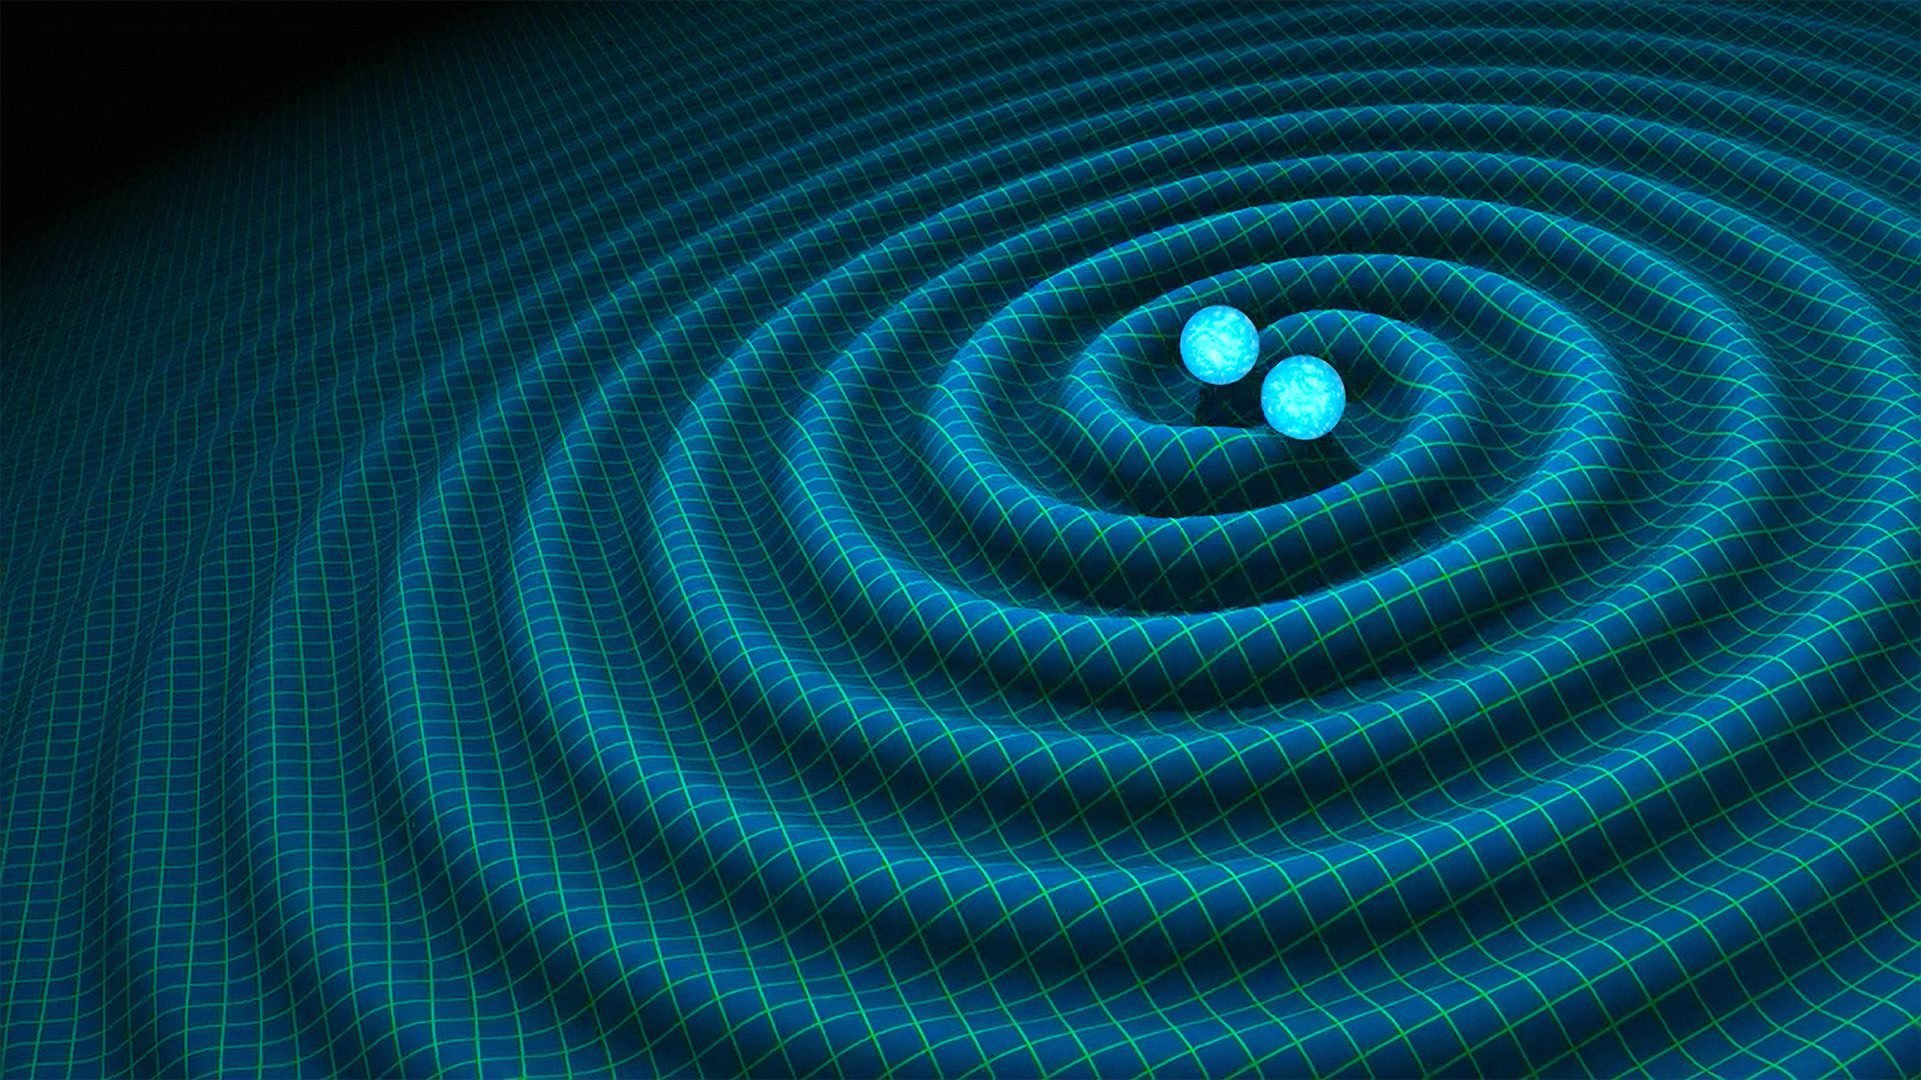

In [14]:
Image('data/gravitational-waves-generated-by-binary-neutron-stars.jpg',width=1000)

### LIGO observatory
The Laser Interferometer Gravitational-Wave Observatory (LIGO) was designed for the direct detection of gravitational waves. It is made up of two identical and widely separated interferometers that look like this: 

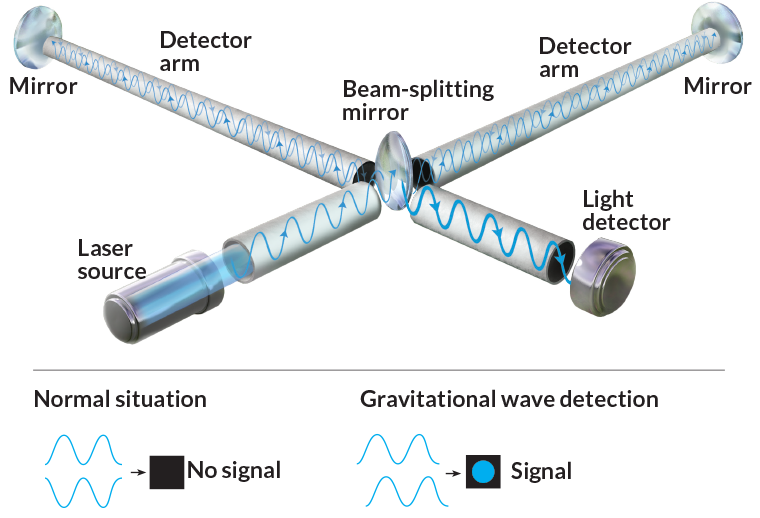

In [15]:
Image('data/100317_nobel-physics_inline_ligo-diagram.png', width=1000)

Image credit: NICOLLE RAGER FULLER

### Nobel Price Physics:
Rainer Weiss, Barry Barish, and Kip Thorne won the 2017 Nobel Prize in Physics for their work on GWs

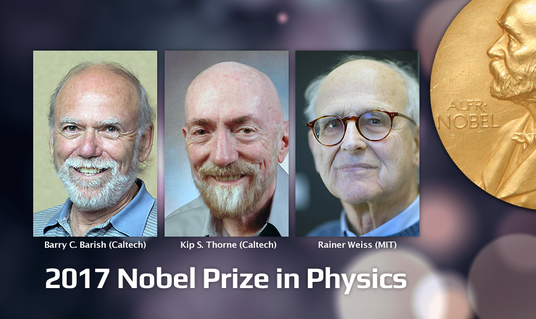

In [16]:
Image('data/Nobel-barish-thorne-weiss_edit.png', width=600)

Image credit: LIGO/Caltech/MIT

### What do Gravitation Wave signals look like?

This is the data from the first GW detection. The first row shows the time series observed, the second the expected signal from simulations, and the third the intensity of each frequency in time from the observed data. The left column corresponds to the Hanford detector in Washington, and the right column to the Livingston detector in Louisiana.  The GW was seen by both detectors, as expected for a real event.

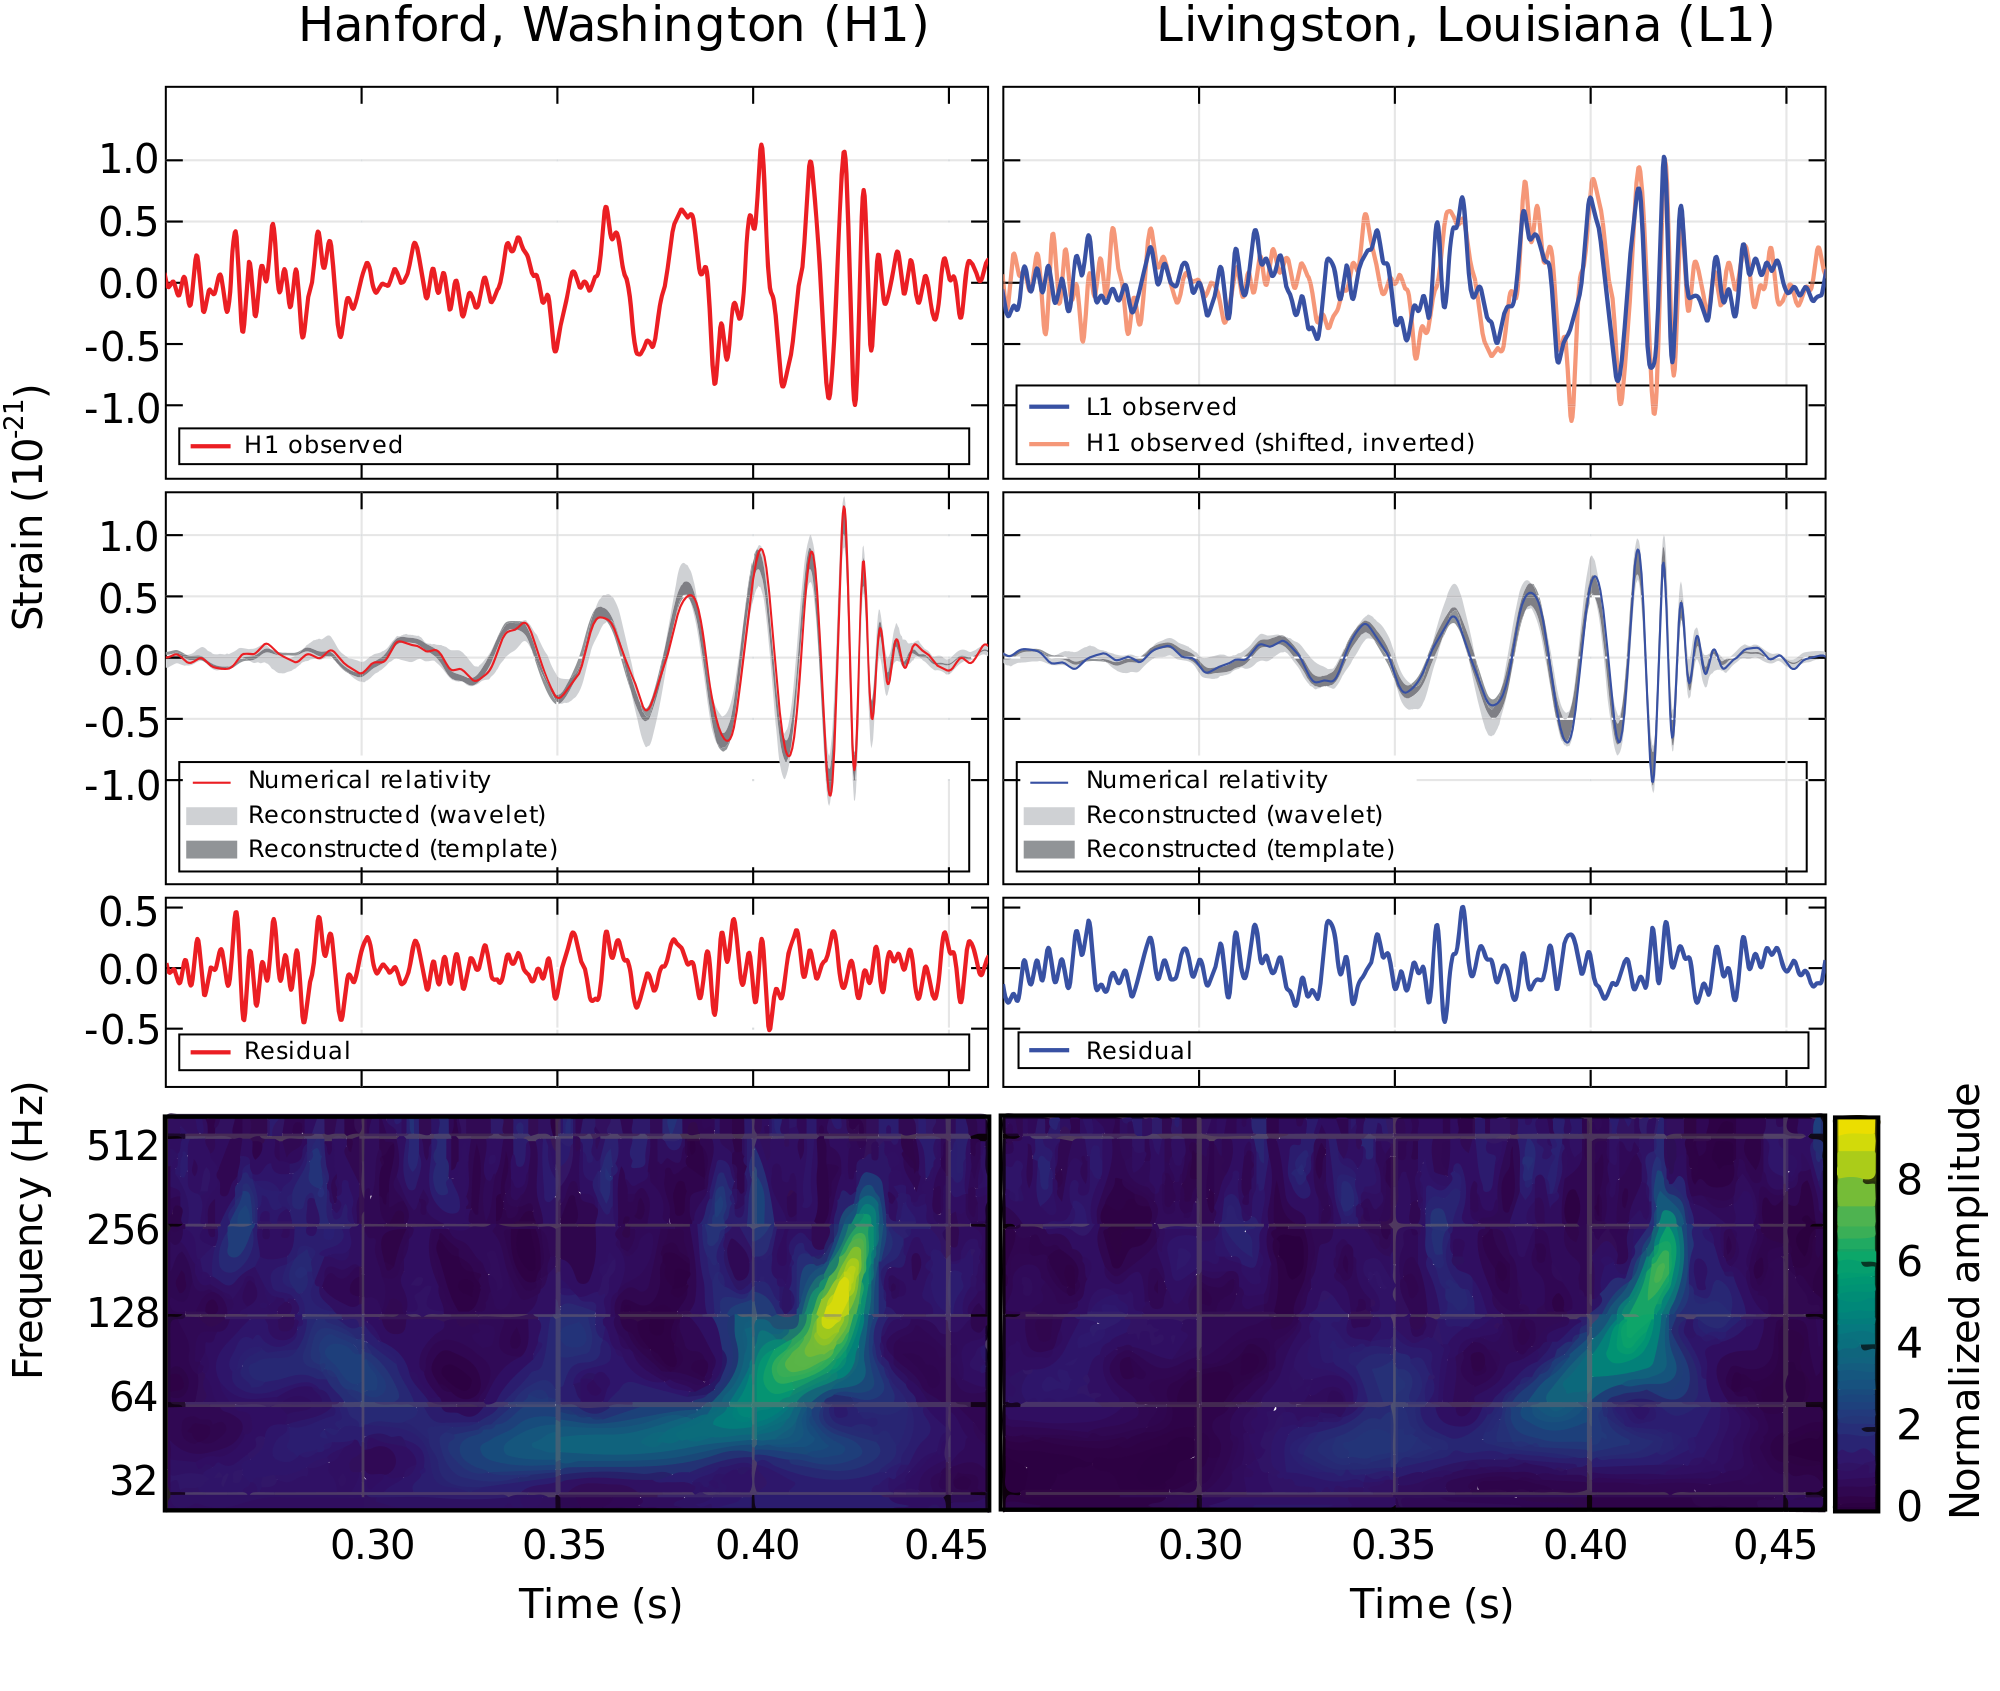

In [17]:
Image('data/LIGO_measurement_of_gravitational_waves.svg.png', width=1100)

Phys. Rev. Lett. 116, 061102 (2016) (https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)

<div class='exercise'><b> Question 3: Building a CNN for Classification of Gravity Wave Events [33.3333 pts] </b></div>

You have built, trained, evaluated and inspected neural networks on a few common datasets such as MNIST or CIFAR10. Now it's time to try a real-world dataset. We want you to consider the problem of classifying images as either gravitational waves or non-detection events using images from two detectors, one from the LIGO Hanford and LIGO Livingston.

 You may find it helpful to gain some domain knowledge on gravitational wave detection. Browse through the information at the following links:



- https://www.ligo.caltech.edu/page/gravitational-waves 
- https://www.zooniverse.org/projects/zooniverse/gravity-spy 

Choose appropriate methods and visualizations to draw conclusions and answer the following questions.

<span class='sub-q'>**3.1 Learn about Gravitational Wave Detection. Load and Clean the Data.**</span>

**3.1.1** Why do you think it is important to have data from both detectors? How might you combine observations from the two detectors into a single observation? 
   

<div class="alert alert-block alert-info">

Having two detectors allows might help to elliminate false positives and confirm findings. 

<br> <br>

Two combine obvservations from two detecotrs together, we can add the second observation as another channel to the input shape.

</div>

We've provided you with two files containing data in the form of numpy objects:

- 'data/GW_aug.npy' (data about Gravitational Wave events)

- 'data/ND_aug.npy' (data about non-detection events)  

**3.1.2** Load and read these data files into variables named `GW` and `ND` respectively. Visualize the differences between the two types of signals and then combine and prepare them for the NN by a) making a numerical response variable that is 1 for `GWs` and 0 for `ND` and b) splitting in `X_train`, `y_train`, `X_test`, and `y_test`. Have 20% of your data be in the test set.

**Hints**:
  - Scale and shuffle the data before you create the training and testing sets. 

In [8]:
# load data
GW = np.load('data/GW_aug.npy')
ND = np.load('data/ND_aug.npy')

In [9]:
print('Shape of GW and ND')
print(GW.shape)
print(ND.shape)

Shape of GW and ND
(1568, 39, 100, 2)
(1216, 39, 100, 2)


<div class="alert alert-block alert-info">

<b> Gravitaional Waves </b>

</div>

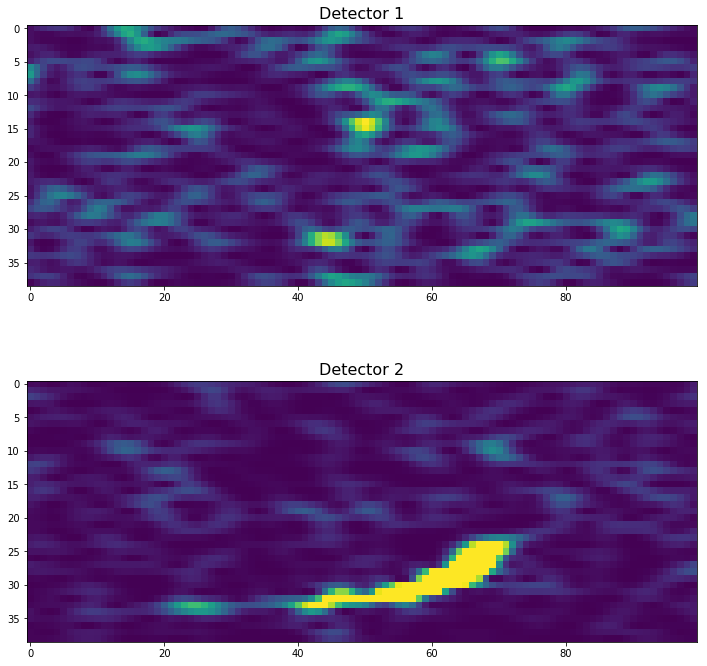

In [10]:
# plot
fig, ax = plt.subplots(2,1, figsize= (12,12))
ax[0].set_title('Detector 1', fontsize= 16)
ax[0].imshow(GW[0,:,:,0])
ax[1].set_title('Detector 2', fontsize= 16)
ax[1].imshow(GW[0,:,:,1]);

<div class="alert alert-block alert-info">

<b> Non detection events </b>

</div>

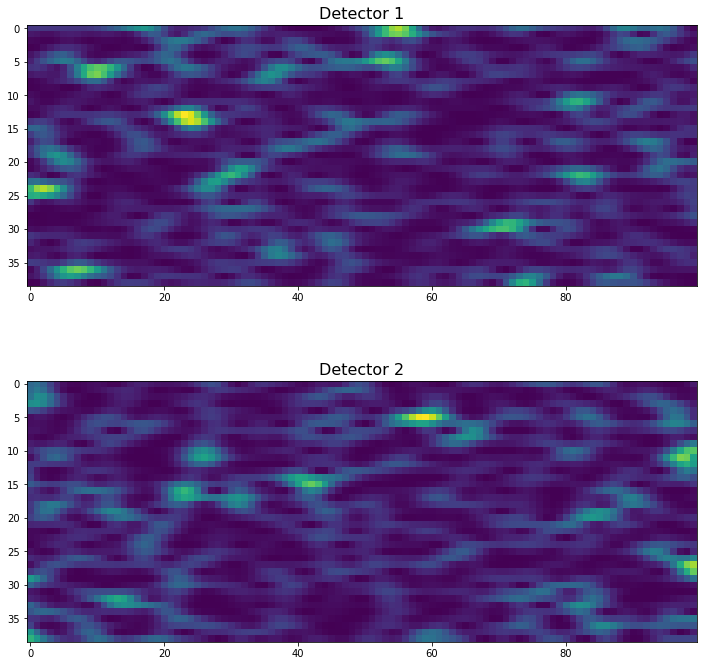

In [11]:
# plot
fig, ax = plt.subplots(2,1, figsize= (12,12))
ax[0].set_title('Detector 1', fontsize= 16)
ax[0].imshow(ND[0,:,:,0])
ax[1].set_title('Detector 2', fontsize= 16)
ax[1].imshow(ND[0,:,:,1]);

In [12]:
# GW labels
y_GW_0 = np.zeros(GW.shape[0], 'int').reshape(-1,1)
y_GW_1 = np.ones(GW.shape[0], 'int').reshape(-1,1)
y_GW = np.hstack((y_GW_0, y_GW_1))

In [13]:
print('GW shape and inspection')
print()
print(y_GW.shape)
display(y_GW[:10])
display(y_GW[-10:])

GW shape and inspection

(1568, 2)


array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [14]:
# ND labels
y_ND_0 = np.ones(ND.shape[0], 'int').reshape(-1,1)
y_ND_1 = np.zeros(ND.shape[0], 'int').reshape(-1,1)
y_ND = np.hstack((y_ND_0, y_ND_1))

In [15]:
print('ND shape and inspection')
print()
print(y_ND.shape)
display(y_ND[:10])
display(y_ND[-10:])

ND shape and inspection

(1216, 2)


array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [16]:
# combine data
x_train = np.vstack((GW,ND))
y_train = np.vstack((y_GW, y_ND))

In [17]:
print('Shape of X and y')
print(x_train.shape)
print(y_train.shape)

Shape of X and y
(2784, 39, 100, 2)
(2784, 2)


In [18]:
print('Inspecting y labels')
display(y_train[:10])
display(y_train[-10:])

Inspecting y labels


array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [19]:
# scale
x_train = x_train/x_train.max()

In [20]:
# mask
np.random.seed(1234)
msk = np.arange(x_train.shape[0])
np.random.shuffle(msk)

In [21]:
# before msk
display(x_train[msk[0],0,0,:])

array([0.03146195, 0.01007528])

In [22]:
# suffle data 
x_train = x_train[msk,...]
y_train = y_train[msk,...]

In [23]:
# after msk
display(x_train[0,0,0,:])

array([0.03146195, 0.01007528])

In [24]:
# split data
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=5214)

<span class='sub-q'> **3.2 Build a CNN Model for GW detection.**</span>

Build a CNN Model to automatically classify event as a GW or an ND. Use a combination of layers such as Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order). 

Summarize your results in a short report. Explain why you chose the architecture you did, described what worked and what didn't. Also describe how did you proceeded to inspect your network as in Q2.


In [75]:
def build_cnn_gw(filter_size, dense_size, X, y):
    # build model
    cnn = Sequential()
    cnn.add(Conv2D(filters= filter_size, kernel_size= (3,3), 
                   strides= (1,1), padding= 'valid', input_shape= X.shape[1:],
                   activation= 'relu', kernel_initializer = 'glorot_normal'))
    cnn.add(MaxPooling2D(pool_size= (2, 2), strides= (2,2)))
    cnn.add(Conv2D(filters= filter_size, kernel_size= (3,3), 
                   strides= (1,1), padding= 'valid', input_shape= X.shape[1:], 
                   activation= 'relu',  kernel_initializer = 'glorot_normal'))
    cnn.add(MaxPooling2D(pool_size= (2, 2), strides= (2,2)))
    cnn.add(Flatten())
    n_flatten = cnn.layers[-1].output_shape[1]
    cnn.add(Dense(dense_size, activation='relu', kernel_initializer = 'glorot_normal'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(2, activation='sigmoid',  kernel_initializer = 'glorot_normal'))

    callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
    cnn.summary()
    
    return(cnn)

<div class="alert alert-block alert-info">

GW Model 1: filter size of 32 and dense layer of 256

</div>

In [67]:
# build it 
gw1 = build_cnn_gw(filter_size= 32, dense_size= 256, X= X_train, y= y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 37, 98, 32)        608       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 49, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 23, 32)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5888)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               1507584   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

Train on 1781 samples, validate on 446 samples
Epoch 1/30
1781/1781 [==============================] - 1s 568us/step - loss: 0.3322 - acc: 0.8122 - val_loss: 0.1567 - val_acc: 0.9518
Epoch 2/30
1781/1781 [==============================] - 0s 259us/step - loss: 0.1088 - acc: 0.9655 - val_loss: 0.0873 - val_acc: 0.9753
Epoch 3/30
1781/1781 [==============================] - 0s 242us/step - loss: 0.0537 - acc: 0.9871 - val_loss: 0.0716 - val_acc: 0.9821
Epoch 4/30
1781/1781 [==============================] - 0s 237us/step - loss: 0.0371 - acc: 0.9907 - val_loss: 0.0548 - val_acc: 0.9843
Epoch 5/30
1781/1781 [==============================] - 0s 236us/step - loss: 0.0238 - acc: 0.9944 - val_loss: 0.0346 - val_acc: 0.9922
Epoch 6/30
1781/1781 [==============================] - 0s 238us/step - loss: 0.0116 - acc: 0.9969 - val_loss: 0.0274 - val_acc: 0.9955
Epoch 7/30
1781/1781 [==============================] - 0s 238us/step - loss: 0.0109 - acc: 0.9966 - val_loss: 0.0335 - val_acc: 0.9865
E

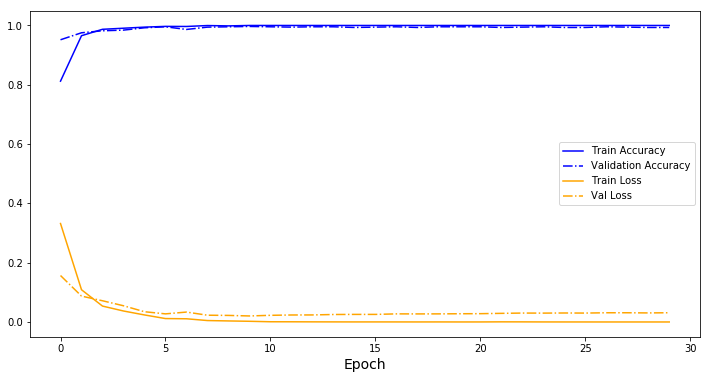

In [68]:
# compile it
gw1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# fit it
gw1.fit(X_train, y_train, 
     batch_size = 64,
     epochs= 30,
     validation_split= 0.2)

# plot cnn
plot_nn_2(gw1)

<div class="alert alert-block alert-info">

GW Model 2: filter size of 64 and dense layer of 256

</div>

In [70]:
# build it 
gw2 = build_cnn_gw(filter_size= 64, dense_size= 256, X= X_train, y= y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 37, 98, 64)        1216      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 18, 49, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 23, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 11776)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               3014912   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
__________

Train on 1781 samples, validate on 446 samples
Epoch 1/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.2994 - acc: 0.8560 - val_loss: 0.1494 - val_acc: 0.9462
Epoch 2/30
1781/1781 [==============================] - 1s 422us/step - loss: 0.1296 - acc: 0.9503 - val_loss: 0.0945 - val_acc: 0.9697
Epoch 3/30
1781/1781 [==============================] - 1s 422us/step - loss: 0.0611 - acc: 0.9843 - val_loss: 0.0761 - val_acc: 0.9765
Epoch 4/30
1781/1781 [==============================] - 1s 420us/step - loss: 0.0375 - acc: 0.9905 - val_loss: 0.0641 - val_acc: 0.9821
Epoch 5/30
1781/1781 [==============================] - 1s 420us/step - loss: 0.0248 - acc: 0.9933 - val_loss: 0.0337 - val_acc: 0.9877
Epoch 6/30
1781/1781 [==============================] - 1s 422us/step - loss: 0.0098 - acc: 0.9978 - val_loss: 0.0272 - val_acc: 0.9933
Epoch 7/30
1781/1781 [==============================] - 1s 424us/step - loss: 0.0041 - acc: 0.9994 - val_loss: 0.0248 - val_acc: 0.9944
Epo

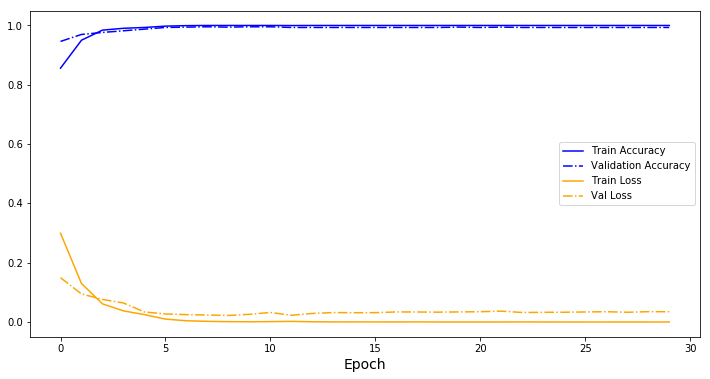

In [71]:
# compile it
gw2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# fit it
gw2.fit(X_train, y_train, 
     batch_size = 64,
     epochs= 30,
     validation_split= 0.2)

# plot cnn
plot_nn_2(gw2)

<div class="alert alert-block alert-info">

GW Model 3: filter size of 32 and dense size of 512

</div>

In [76]:
# build it 
gw3 = build_cnn_gw(filter_size= 32, dense_size= 512, X= X_train, y= y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 37, 98, 32)        608       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 49, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 23, 32)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 5888)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               3015168   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
__________

Train on 1781 samples, validate on 446 samples
Epoch 1/30
1781/1781 [==============================] - 1s 687us/step - loss: 0.3290 - acc: 0.8509 - val_loss: 0.1502 - val_acc: 0.9540
Epoch 2/30
1781/1781 [==============================] - 0s 273us/step - loss: 0.1276 - acc: 0.9551 - val_loss: 0.1107 - val_acc: 0.9641
Epoch 3/30
1781/1781 [==============================] - 0s 269us/step - loss: 0.0665 - acc: 0.9826 - val_loss: 0.0692 - val_acc: 0.9798
Epoch 4/30
1781/1781 [==============================] - 0s 272us/step - loss: 0.0378 - acc: 0.9902 - val_loss: 0.0528 - val_acc: 0.9798
Epoch 5/30
1781/1781 [==============================] - 0s 271us/step - loss: 0.0231 - acc: 0.9941 - val_loss: 0.0318 - val_acc: 0.9955
Epoch 6/30
1781/1781 [==============================] - 0s 272us/step - loss: 0.0095 - acc: 0.9983 - val_loss: 0.0264 - val_acc: 0.9933
Epoch 7/30
1781/1781 [==============================] - 0s 278us/step - loss: 0.0034 - acc: 0.9997 - val_loss: 0.0276 - val_acc: 0.9955
E

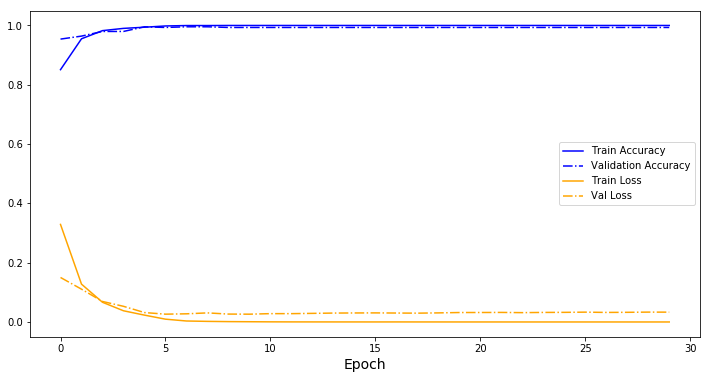

In [77]:
# compile it
gw3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# fit it
gw3.fit(X_train, y_train, 
     batch_size = 64,
     epochs= 30,
     validation_split= 0.2)

# plot cnn
plot_nn_2(gw3)

<div class="alert alert-block alert-info">

GW Model 4: filter size of 64 and dense size of 512

</div>

In [79]:
# build it 
gw4 = build_cnn_gw(filter_size= 64, dense_size= 512, X= X_train, y= y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 37, 98, 64)        1216      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 49, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 23, 64)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 11776)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               6029824   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
__________

Train on 1781 samples, validate on 446 samples
Epoch 1/30
1781/1781 [==============================] - 2s 1ms/step - loss: 0.2760 - acc: 0.8546 - val_loss: 0.1512 - val_acc: 0.9383
Epoch 2/30
1781/1781 [==============================] - 1s 490us/step - loss: 0.0888 - acc: 0.9733 - val_loss: 0.0883 - val_acc: 0.9753
Epoch 3/30
1781/1781 [==============================] - 1s 492us/step - loss: 0.0406 - acc: 0.9882 - val_loss: 0.0484 - val_acc: 0.9821
Epoch 4/30
1781/1781 [==============================] - 1s 487us/step - loss: 0.0175 - acc: 0.9964 - val_loss: 0.0247 - val_acc: 0.9978
Epoch 5/30
1781/1781 [==============================] - 1s 489us/step - loss: 0.0088 - acc: 0.9983 - val_loss: 0.0242 - val_acc: 0.9944
Epoch 6/30
1781/1781 [==============================] - 1s 489us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0265 - val_acc: 0.9933
Epoch 7/30
1781/1781 [==============================] - 1s 502us/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0275 - val_acc: 0.9955
Epo

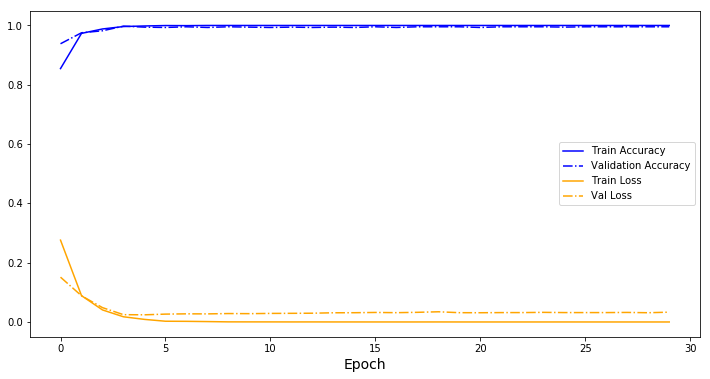

In [80]:
# compile it
gw4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# fit it
gw4.fit(X_train, y_train, 
     batch_size = 64,
     epochs= 30,
     validation_split= 0.2)

# plot cnn
plot_nn_2(gw4)

In [82]:
# save models 
gw1.save('gw1.h5')
gw2.save('gw2.h5')
gw3.save('gw3.h5')
gw4.save('gw4.h5')

In [7]:
# save models 
gw1 = load_model('gw1.h5')
# load_model('gw2.h5')
# load_model('gw3.h5')
# load_model('gw4.h5')

<div class="alert alert-block alert-info">

Evaluate

</div>

In [83]:
print(gw1.evaluate(X_test, y_test))

557/557 [==============================] - 0s 141us/step
[0.03661066094151413, 0.9919210053859964]


In [73]:
print(gw2.evaluate(X_test, y_test))

557/557 [==============================] - 0s 340us/step
[0.0440245891749682, 0.992818671454219]


In [78]:
print(gw3.evaluate(X_test, y_test))

557/557 [==============================] - 0s 148us/step
[0.025598389149044266, 0.992818671454219]


In [81]:
print(gw4.evaluate(X_test, y_test))

557/557 [==============================] - 0s 231us/step
[0.03023924619609221, 0.9910233393177738]


<div class="alert alert-block alert-info">

In the above metric and plots, we see very high accuracy across the board. Since the number of gravitational events and non-detection events are roughly in proportion in the dataset, accuracy should be a good measure of performance (i.e. there isn't the discrepency with accuracy that would accompnay severly ill-proportioned classes). There must be some systemic reason why we are misclassifying certain points. 

</div>

<div class="alert alert-block alert-info">

In choosing our architecture, I felt like two convolutional layers would be sufficient to capture the imporant features in the images of the waves. This architecture seemed to work well in the previous model, so I chose to use it once more. Unlike the previous architecture, however, I chose to implement pooling after each convolution to reduce the dimensionality of the intermediate inputs; this helps reduce the number of parameters and keeps the model workable. Like the previous architecture, I implemented dense and dropout layers after the flatten layer, this time only one of each to control the number of parameters. The varaition between the models is on the filter size and the size of the dense layer. Ultimately, all the models perform well.


</div>

<div class="alert alert-block alert-info">

In choosing our architecture, I felt like two convolutional layers would be sufficient to capture the imporant features in the images of the waves. This architecture seemed to work well in the previous model, so I chose to use it once more. Unlike the previous architecture, however, I chose to implement pooling after each convolution to reduce the dimensionality of the intermediate inputs; this helps reduce the number of parameters and keeps the model workable. Like the previous architecture, I implemented dense and dropout layers after the flatten layer, this time only one of each to control the number of parameters. The varaition between the models is on the filter size and the size of the dense layer. Ultimately, all the models perform well.


</div>

<div class="alert alert-block alert-info">

Work witht the simplest model. Find out why we missclassified. 

</div>

In [86]:
preds = gw1.predict(X_test)
preds_class = preds.argmax(-1)
ind = np.where(preds_class != y_test.argmax(-1))[0][0]
datum = X_test[ind,...]
image = X_test[ind,:,:,0]
image2 = X_test[ind,:,:,1]

In [69]:
image.shape

(39, 100)

In [70]:
# class
y_test[ind].argmax(-1)

0

In [73]:
# Swap softmax with linear
gw1.layers[-1].activation = activations.linear
gw1 = utils.apply_modifications(gw1)
grads = visualize_saliency(gw1, -1, filter_indices=0, seed_input=datum)

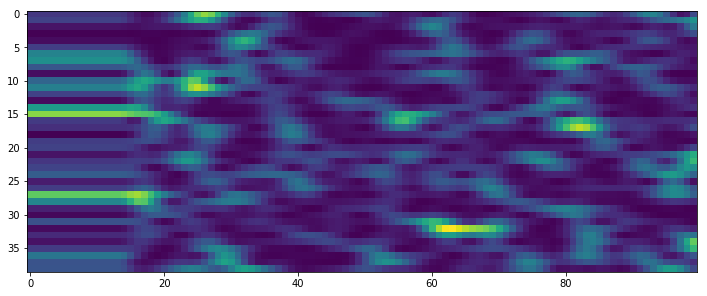

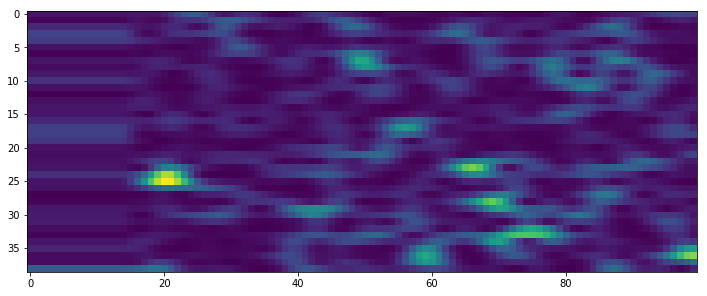

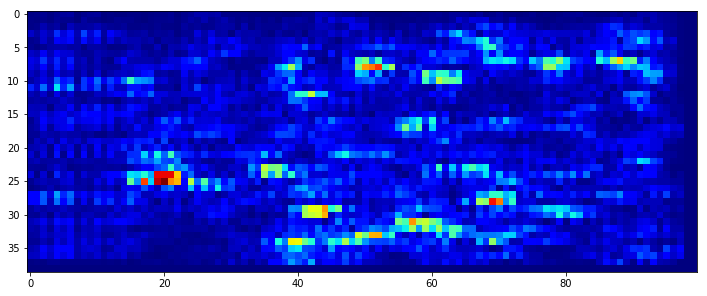

In [87]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
ax.imshow(image)
fig, ax = plt.subplots(1,1, figsize=(12,12))
ax.imshow(image2)
fig, ax = plt.subplots(1,1, figsize=(12,12))
# Plot with 'jet' colormap to visualize as a heatmap.
ax.imshow(grads, cmap='jet');

<div class="alert alert-block alert-info">

From the above plots, we see why this image might have been flagged as a gravitational image when it's not. There looks to be activation in severral distinct regions that appears to show a rippple like a gravitational image might. Further, in looking at the original image from the first detector, there seems to be some streaks in the image that seem abnormal - at least to me, someone without the expert knowledge background for this field. What we may be seeing in the points that were missclassified is the result of a malfunction in the detectors - at least from an intital inspection. 

</div>

In [ ]:
2+2